In [1]:
%load_ext autoreload 
%autoreload 2 

In [15]:

import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec # for subplots
import pandas as pd
import numpy as np
import seaborn as sns
import seaborn.objects as so
import tensorflow as tf

#### Load Model

In [ ]:
lstm_03_path = '/projects/p31961/dopamine_modeling/results/models/LSTM_03_simple_downsampled'
lstm_03 = tf.keras.models.load_model(lstm_03_path)

# Model Summary

In [5]:
lstm_03.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, None, 1)           0         
                                                                 
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


#### load training and testing data

In [6]:
dataset_dir = '/projects/p31961/gaby_data/aggregated_data/data_pipeline_downsampled/datasets'
X_train_path = os.path.join(dataset_dir, '5_day_training_gaby_downsampled_X_train.parquet.gzip')
X_test_path = os.path.join(dataset_dir, '5_day_training_gaby_downsampled_X_test.parquet.gzip')
y_train_path = os.path.join(dataset_dir, '5_day_training_gaby_downsampled_y_train.parquet.gzip')
y_test_path = os.path.join(dataset_dir, '5_day_training_gaby_downsampled_y_test.parquet.gzip')

X_train = pd.read_parquet(X_train_path)
X_test = pd.read_parquet(X_test_path)
y_train = pd.read_parquet(y_train_path)
y_test = pd.read_parquet(y_test_path)

In [7]:
prediction = lstm_03.predict(X_test)

49576/49576 [==============================] - 67s 1ms/step


# Full dataset

In [8]:
full_dataset = X_test.assign(predicted_signal = prediction,
                             true_signal = y_test['signal'])
full_dataset.head()


,day,time,trial,event_cue,event_shock,sensor_D1,sensor_D2,sensor_DA,predicted_signal,true_signal
0,6,-25.000000,0,0,0,1,0,0,0.168234,-0.047544
1,6,-24.901531,0,0,0,1,0,0,0.167285,0.115965
2,6,-24.803064,0,0,0,1,0,0,0.166279,-0.046369
3,6,-24.704596,0,0,0,1,0,0,0.165214,-0.030047
4,6,-24.606127,0,0,0,1,0,0,0.164089,0.461070


In [ ]:
sensor_cols = ['sensor_DA', 'sensor_D1', 'sensor_D2']
event_cols = ['event_cue', 'event_shock']
signal_cols = ['predicted_signal', 'true_signal']

def reshape_df(df):
    sensor_cols = ['sensor_DA', 'sensor_D1', 'sensor_D2']
    event_cols = ['event_cue', 'event_shock']
    signal_cols = ['predicted_signal', 'true_signal']
    return (df
            # .drop(columns = ['trial'])
            .assign(sensor = lambda df_: df_[sensor_cols].idxmax(axis = 1).str.replace('sensor_', ''),
                   event = lambda df_: df_[event_cols].idxmax(axis = 1).str.replace('event_', ''))
            .melt(id_vars = ['day', 'time', 'trial', 'sensor', 'event'], 
                 value_vars = signal_cols, 
                 var_name = 'signal_type', 
                 value_name='z_score')
            .assign(signal_type = lambda df_: df_['signal_type'].str.replace('_signal', ''))
        #    .drop(columns = sensor_cols + event_cols)

           )   
reshaped_df = reshape_df(full_dataset)

In [ ]:

# test_df = reshaped_df[::100].reset_index(drop = True)
(
    so.Plot(reshaped_df, x = 'time', y = 'true_signal').layout(size = (10,10))
    .facet(col = 'sensor', row = 'event')
    .add(so.Band(), so.Est())
    .add(so.Line(linewidth=1), so.Agg())
)


In [54]:
def plot_data(data, day, event, sensor, ax):
    sns.lineplot(data = data, x = 'time', y = 'true_signal', color = 'black', label = 'true signal', ax = ax)
    sns.lineplot(data = data, x = 'time', y = 'predicted_signal', color = 'red', label = 'predicted signal', ax = ax)
    sns.despine()
    ax.set_ylim(-1.5, 1.5)
    ax.set_xlim(-25, 20)
    ax.set_title(f'Day: {day}, Event: {event}, Sensor: {sensor}')
    ax.set_ylabel('Z-score')
    ax.set_xlabel('Time (s)')
    legend = ax.legend()

# Remove the legend outline
    legend.get_frame().set_linewidth(0)

### queries

In [10]:

day_6_da_query = "day==6 & event_cue== 1 & sensor_DA==1 "
day_6_cue_DA_query_result = full_dataset.query(day_6_da_query).drop(columns = ['event_shock', 'sensor_D1', 'sensor_D2'])


day_7_da_query = "day==7 & event_cue== 1 & sensor_DA==1 "
day_7_cue_DA_query_result = full_dataset.query(day_7_da_query).drop(columns = ['event_shock', 'sensor_D1', 'sensor_D2'])

day_6_d1_query = "day==6 & event_cue== 1 & sensor_D1==1 "
day_6_d1_query_result = full_dataset.query(day_6_d1_query).drop(columns = ['event_shock', 'sensor_D1', 'sensor_D2'])

day_7_d1_query = "day==7 & event_cue== 1 & sensor_D1==1 "
day_7_d1_query_result = full_dataset.query(day_7_d1_query)

day_6_d2_query = "day==6 & event_cue== 1 & sensor_D2==1 "
day_6_d2_query_result = full_dataset.query(day_6_d2_query)

day_7_d2_query = "day==7 & event_cue== 1 & sensor_D2==1 "
day_7_d2_query_result = full_dataset.query(day_6_d2_query)


# Results for day 6 and day 7 with cue and shock for each sensor

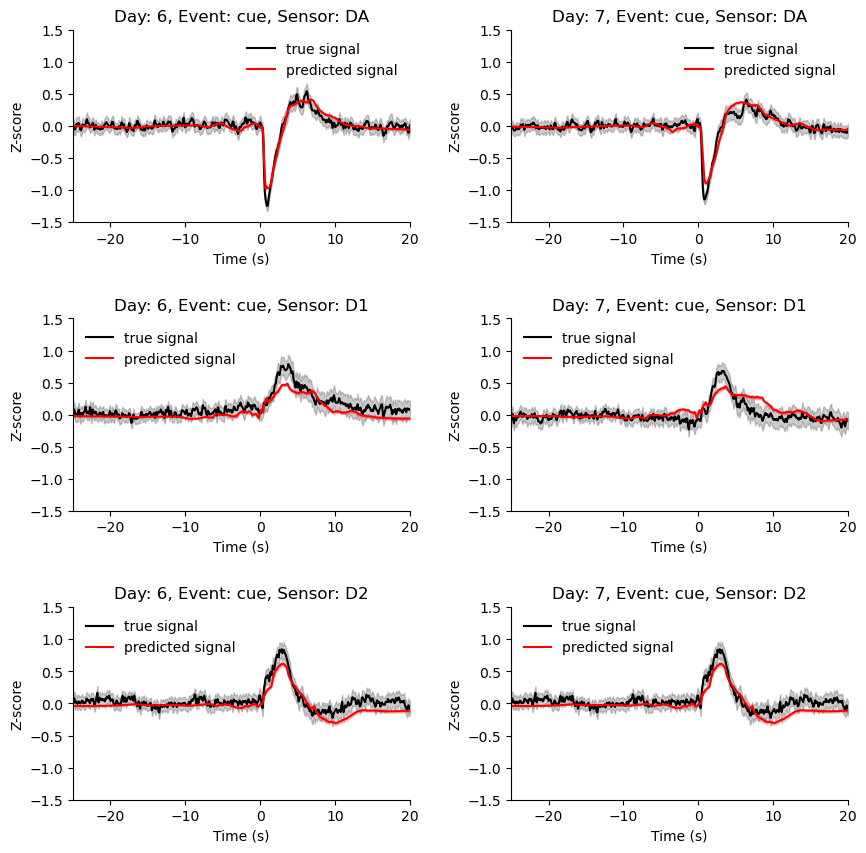

In [55]:
fig = plt.figure(figsize = (10,10))
cols = 2
rows = 3
gs = gridspec.GridSpec(rows, cols)
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1], sharey = ax1)
ax3 = fig.add_subplot(gs[1,0], sharey = ax1)
ax4 = fig.add_subplot(gs[1,1], sharey = ax1)
ax5 = fig.add_subplot(gs[2,0], sharey = ax1)
ax6 = fig.add_subplot(gs[2,1], sharey = ax1)

plot_data(day_6_cue_DA_query_result, 6, 'cue', 'DA', ax = ax1)
plot_data(day_7_cue_DA_query_result, 7, 'cue', 'DA', ax = ax2)
plot_data(day_6_d1_query_result, 6, 'cue', 'D1', ax = ax3)
plot_data(day_7_d1_query_result, 7, 'cue', 'D1', ax = ax4)
plot_data(day_6_d2_query_result, 6, 'cue', 'D2', ax = ax5)
plot_data(day_7_d2_query_result, 7, 'cue', 'D2', ax= ax6)
gs.update(hspace=0.5, wspace=0.3)
plt.show()




# Conclusions 
* First initial training is pretty decent. 
  * Dopamine appears easier to predict that GCaMP

> this model is exceptionally basic with plenty of room for improvements in performance. 

# Next steps

### Add remaining data
* sex
* cross corr
* escape/avoid
___

### Encapsulate model for experimentaiton 
```python 
class SimpleLSTM:
```
____
### Experiments 
   *  Add convolutional for first layer
   *  add additional LSTM layers
   *  add bidirectional layers
   *  gradient decent for optimizer with varying learning rates
   *  add call back for early training termination

___
### Reports
Interactive reports with tensorboard
> not sure this can be done on quest

